# Exploratory Data Analysis

#### January 2023

### Imports and set-up

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import statsmodels.formula.api as smf
import time


In [15]:
# Pulling in the handy-dandy altair plots of excellence for use later


def base_chart(data, yvar, xvar, plottitle, yname, xname, dcolor="grey"):
    chart = (
        alt.Chart(data)
        .mark_point(color=dcolor, opacity=0.5)
        .encode(
            x=alt.X(xvar, title=xname, scale=alt.Scale(zero=False)),
            y=alt.Y(yvar, title=yname, scale=alt.Scale(zero=False)),
        )
        .properties(title=plottitle)
    )
    return chart


def get_reg_fit(data, yvar, xvar, alpha=0.05, dcolor="grey"):

    # Grid for predicted values
    x = data.loc[pd.notnull(data[yvar]), xvar]
    xmin = x.min()
    xmax = x.max()
    step = (xmax - xmin) / 100
    grid = np.arange(xmin, xmax + step, step)
    predictions = pd.DataFrame({xvar: grid})

    # Fit model, get predictions
    model = smf.ols(f"{yvar} ~ {xvar}", data=data).fit()
    model_predict = model.get_prediction(predictions[xvar])
    predictions[yvar] = model_predict.summary_frame()["mean"]
    predictions[["ci_low", "ci_high"]] = model_predict.conf_int(alpha=alpha)

    # Build chart
    reg = (
        alt.Chart(predictions)
        .mark_line(color=dcolor)
        .encode(
            x=alt.X(xvar),
            y=alt.Y(yvar),
        )
    )
    ci = (
        alt.Chart(predictions)
        .mark_errorband(color=dcolor, opacity=0.2)
        .encode(
            x=xvar,
            y=alt.Y("ci_low"),
            y2="ci_high",
        )
    )
    chart = ci + reg

    return predictions, chart


### Data

For this exploration, I'll be using monthly average prices for various commodities that I've collected from the International Monetary Fund (IMF); the data can be found [at this link](https://www.imf.org/en/Research/commodity-prices). The IMF maintains historical prices on a wide variety of commodities and indices from around the world, which it aggregates as a monthly average price in the form I collected.

The dataset contains 94 columns, each representing a unique commodity (from Gold, Silver, and Platinum to Beverage Price Index and Agricultural Price Index). The data spans from January 1990 through December 2022; however, some commodities or indices do not have observations for the entire time (the majority of missingness is on the front end of the data). I'll narrow the focus of this analysis to just precious metals and some popular commodities and omit some of the indices and other lesser-known commodities. The chief relationship I will interrogate is gold and silver, but I'll also look at other associations to see if anything interesting emerges.

The first step will be to ingest the data and examine the resulting dataframe to see what challenges may arise. I already took a look at the data in the excel file when it completed downloading, and I suspect that I will have to do some transformations to a few areas of the data to make this analysis more manageable. I'll start with the import and walk systematically through the cleaning to see how it goes.

In [16]:
# Data ingest

price_df = pd.read_excel(
    "../10_source_data/external-datajanuary.xls"
)
# price_df.head(5)


### Data Cleaning

From an inspection of the data, several challenges are immediately apparent:
* There are a lot of excess columns that I already know I don't need. I'll drop some of the unnecessary columns.
* There appear to be three meaningless rows that are an artifact of the excel format. I'll drop these.
* The month format is going to require transformation to a DateTime format. For example, it is currently stored as "1990M1" to represent January 1990. I'll transform this to a DateTime format.

I'll begin by addressing these things one at a time to arrive at a final dataset.

In [17]:
# First problem: columns

# First, print the column header and value in the first row together to see what we're working with
# for col in price_df.columns:
#     print(col, price_df[col][0])

# Then subset the data to only the columns we want
cols = [
    "Commodity",
    "PNGAS",
    "PALUM",
    "PCOFFROB",
    "PCOPP",
    "PCOTTIND",
    "PLEAD",
    "PNICK",
    "PTIN",
    "PURAN",
    "PCOBA",
    "PGOLD",
    "PSILVER",
    "PPALLA",
    "PPLAT",
    "Unnamed: 90",
]
price_df = price_df[cols]

# Then rename the columns to the first word of the value in the first row
price_df.columns = [
    "Date",
    "Natural Gas",
    "Aluminum",
    "Coffe Robusta",
    "Copper",
    "Cotton",
    "Lead",
    "Nickel",
    "Tin",
    "Uranium",
    "Cobalt",
    "Gold",
    "Silver",
    "Palladium",
    "Platinum",
    "Lithium",
]


In [18]:
# Second problem: rows

# Drop the first three rows
price_df = price_df.drop([0, 1, 2])


In [19]:
# Third problem: date formats

# Convert the date column to a datetime object
price_df["Date"] = pd.to_datetime(price_df["Date"], format="%YM%m")

# Reset the index
price_df = price_df.reset_index(drop=True)


### Exploratory Data Analysis

To examine the price relationships, I'll begin with a series of plots to do a quick visual inspection of the information to see what emerges. From there, I'll identify some relationships of interest and carry on with a deeper dive into those areas. I'll start with a correlation plot matrix to see if there are any relationships that are immediately apparent.

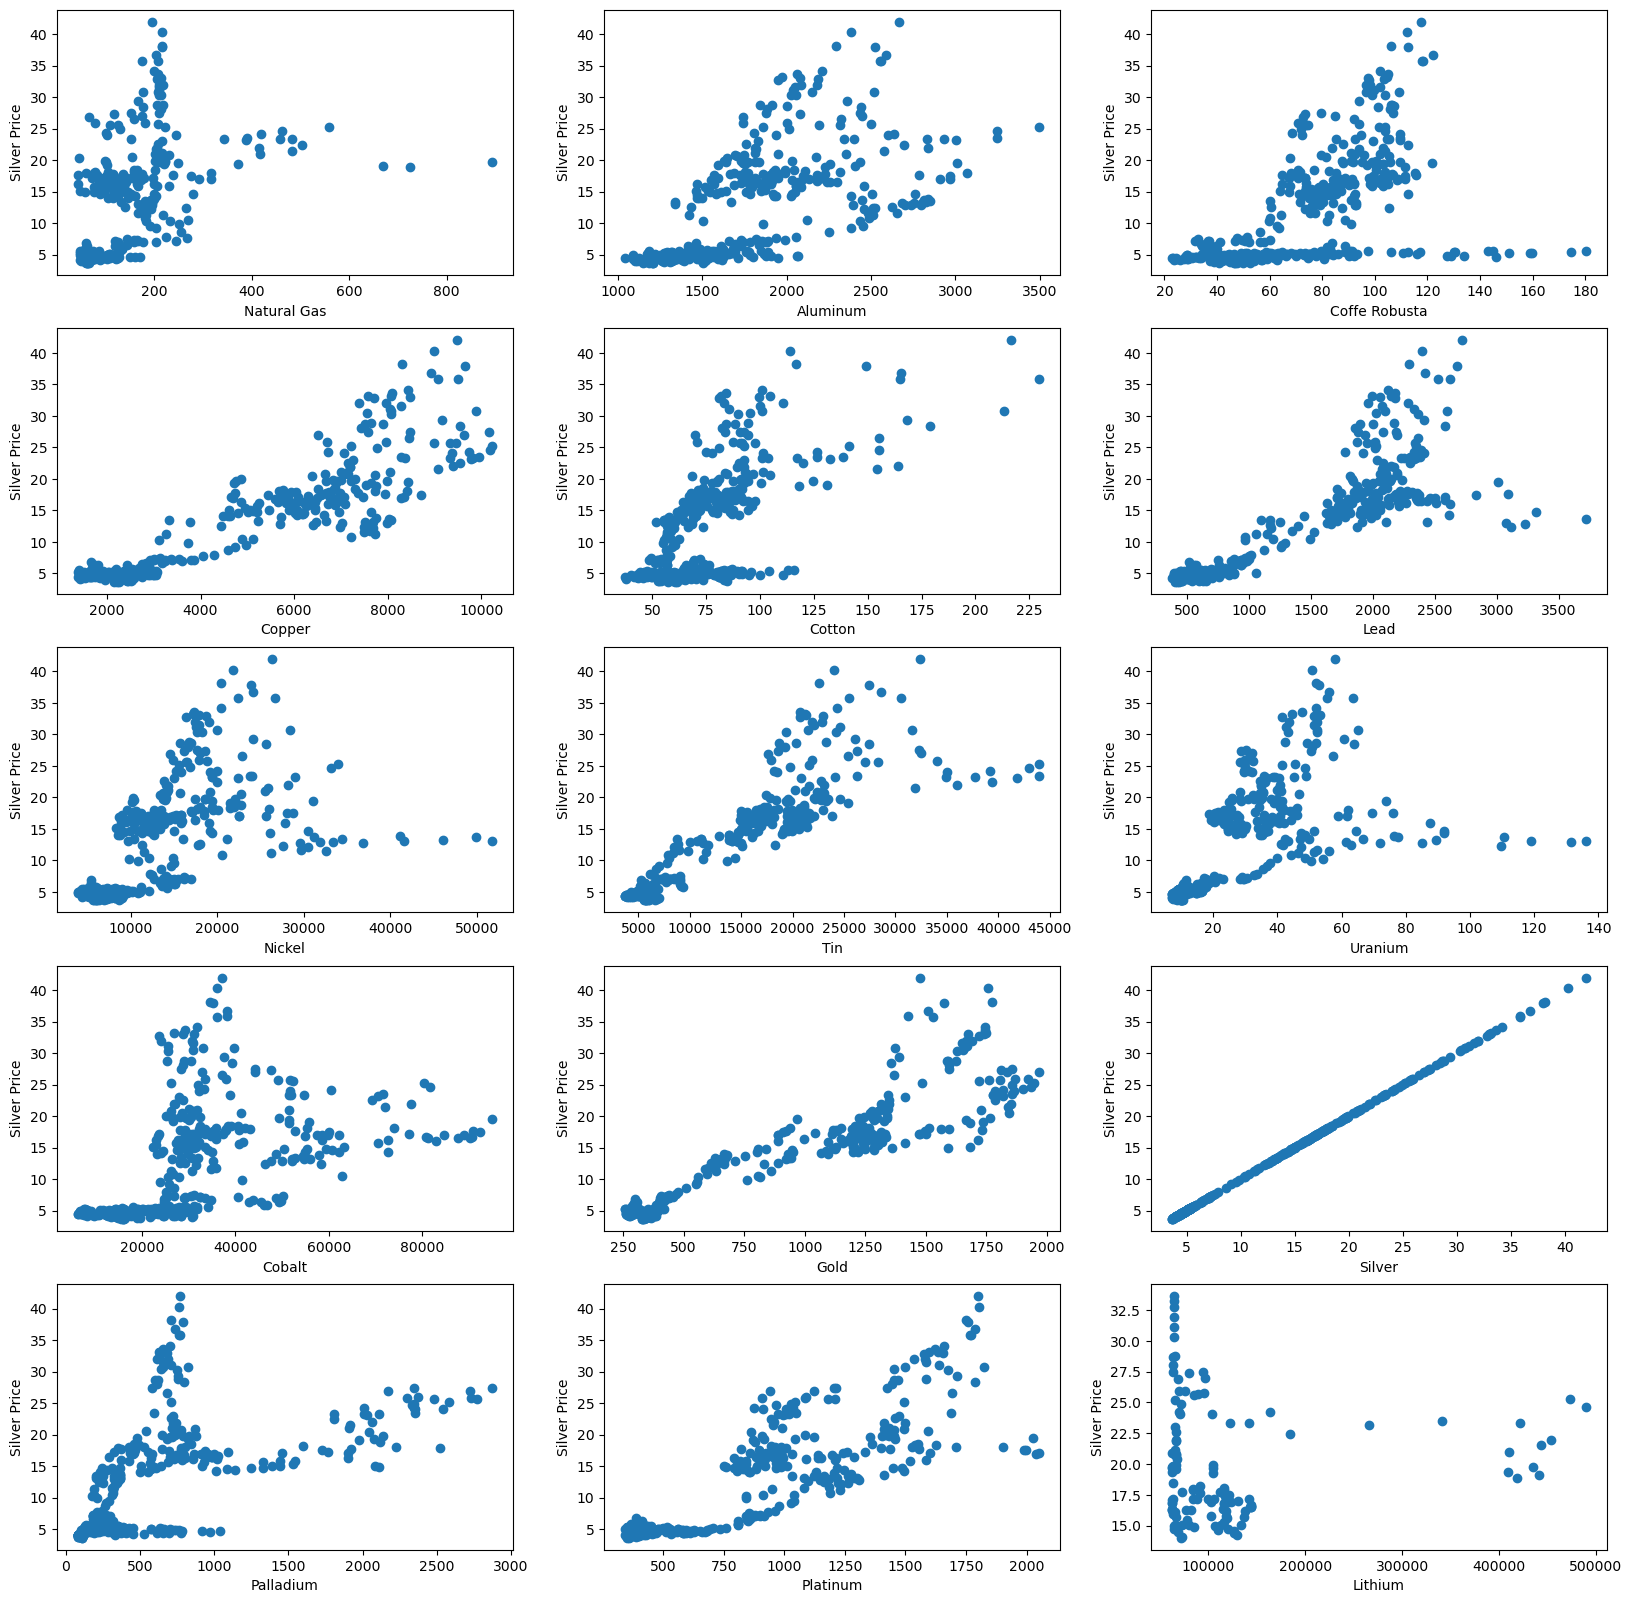

In [20]:
# A matrix of plots with all the columns against the silver price
fig, axs = plt.subplots(5, 3, figsize=(20, 20))
for i, col in enumerate(price_df.columns[1:]):
    axs[i // 3, i % 3].scatter(price_df[col], price_df["Silver"])
    axs[i // 3, i % 3].set_ylabel("Silver Price")
    axs[i // 3, i % 3].set_xlabel(col)


The matrix of plots above shows the prices of the commodities and indices I selected as predictor variables, with the price of silver as the outcome variable. There are a couple of things that I found interesting about this group. First, several commodities appear to have a strong positive relationship with silver, but many of those relationships weaken (sometimes significantly) after a specific price point is surpassed. This effect is best observed on the graph with the price of tin as the predictor. Around a tin price of $17,500, the relationship with silver appears to weaken and level off. This follows how these commodities behave: the price of one item does not affect silver; the prices are symptoms of broader economic sentiment and concepts about where the costs should be. In short, the prices are correlated but not causally related. 

The second observation is that the price of silver has a strong positive relationship with the prices of several commodities. I'll downselect these predictors and examine them further in the next section:
* Gold
* Platinum
* Tin
* Lead
* Copper
* Aluminum

In [21]:
# Downselect the data to only the final predictors of interest

final_cols = ["Date", "Silver", "Gold", "Platinum", "Tin", "Lead", "Copper", "Aluminum"]
final_df = price_df[final_cols].copy()
# final_df.head(5)

# convert columns [1:] to numeric
final_df[final_df.columns[1:]] = final_df[final_df.columns[1:]].apply(
    pd.to_numeric, errors="coerce"
)


Before diving deeper into the analysis, I also want to know generally how the prices of the commodities I've selected have behaved over time. This is an important component of this analysis, given the nature of the question posed. In addition to the price relationships shown above, I would want to see general similarities in the behavior of the commodities I've selected over similar time periods. I also plot gold versus silver over time as this is the primary relationship I'm interested in.

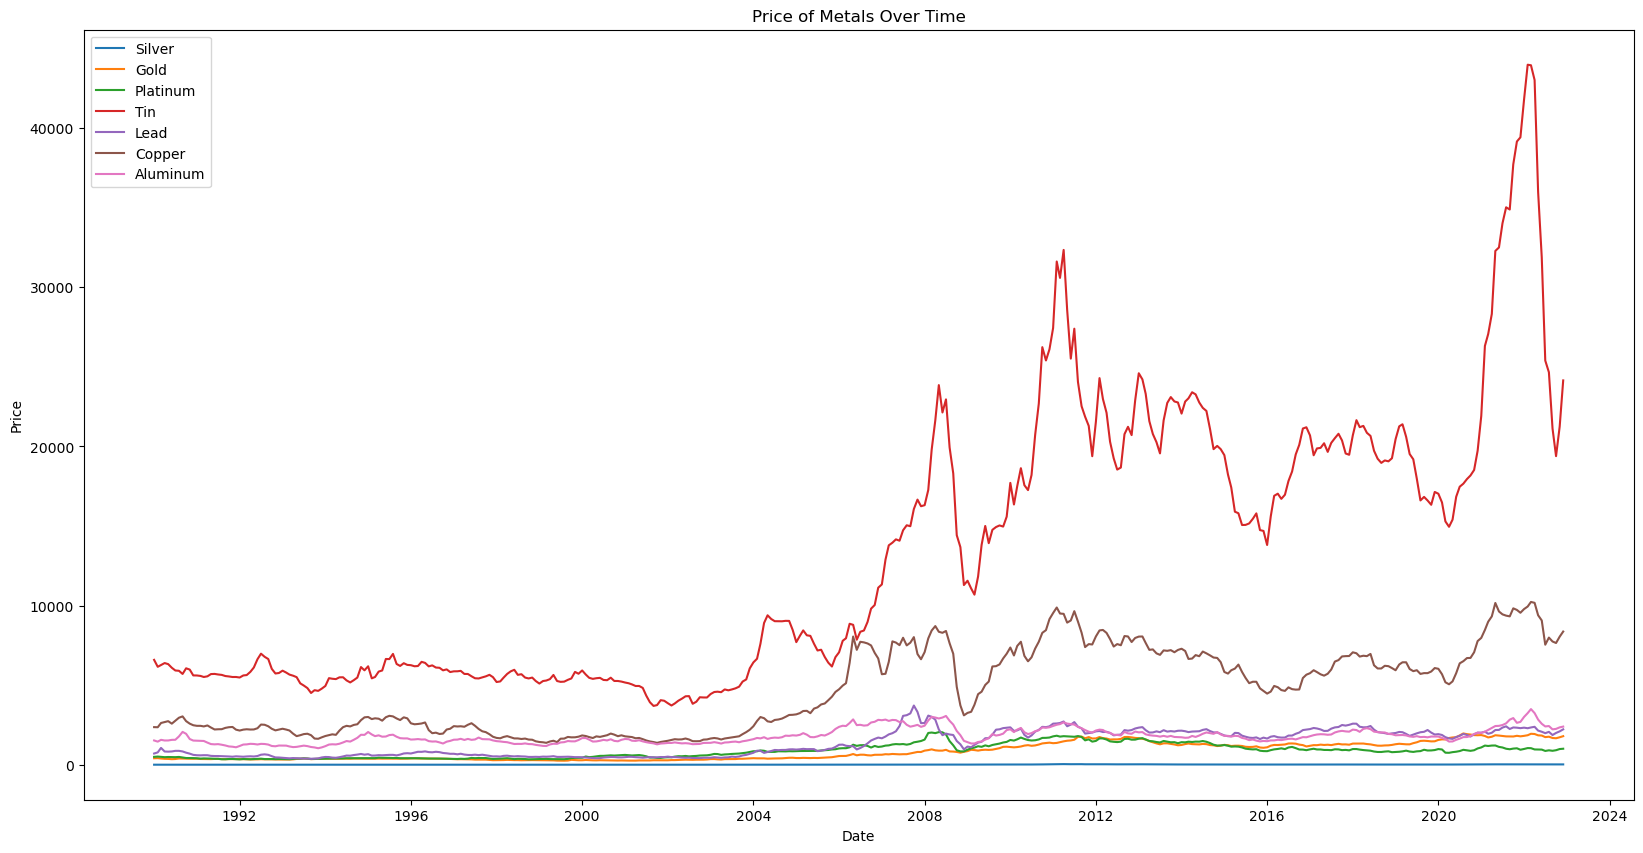

In [22]:
# make a chart of final_df over time
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
for col in final_df.columns[1:]:
    axs.plot(final_df["Date"], final_df[col], label=col)
axs.set_ylabel("Price")
axs.set_xlabel("Date")
axs.title.set_text("Price of Metals Over Time")
axs.legend()


This plot shows the scale between some of the metals that I selected above. Tin has an enormous price range when compared to the other metals, and it also appears to have the most violent swings. This might raise issues later. I also have concerns about copper, which has a large range but much less volatility than silver. It is possible that copper is still a good predictor of silver, but the scale of this graph makes it hard to tell. 

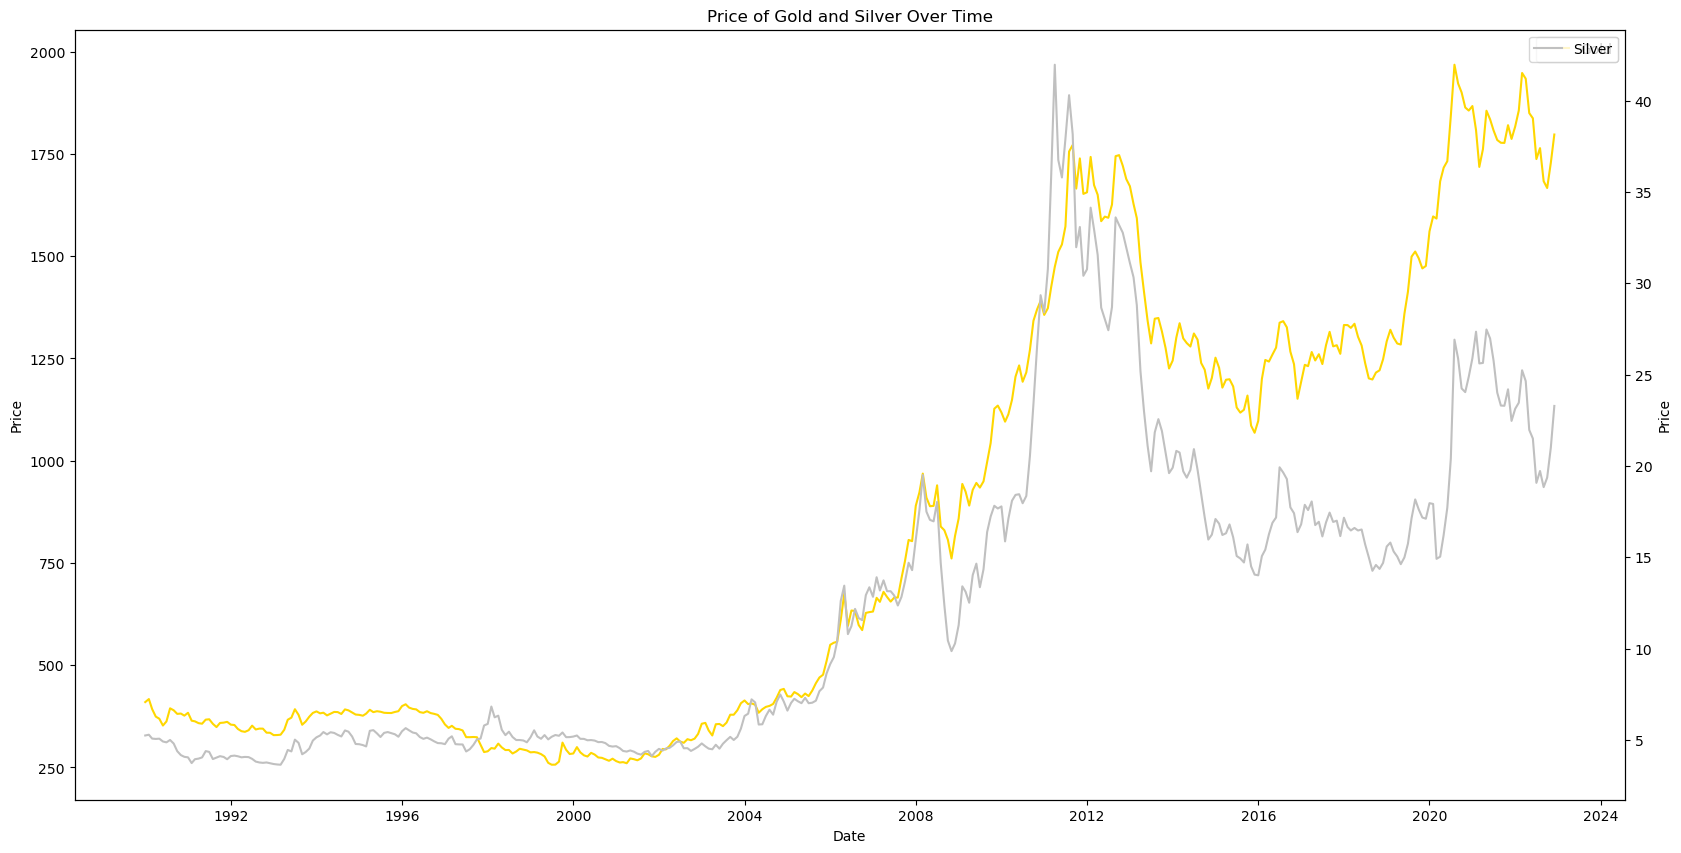

In [23]:
# make a chart of gold and silver over time with silver on a secondary axis
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.plot(final_df["Date"], final_df["Gold"], label="Gold", color="gold")
axs.set_ylabel("Price")
axs.set_xlabel("Date")
axs.title.set_text("Price of Gold and Silver Over Time")
axs.legend()
axs2 = axs.twinx()
axs2.plot(final_df["Date"], final_df["Silver"], label="Silver", color="silver")
axs2.set_ylabel("Price")
axs2.legend()

# save this plot to a file
fig.savefig("../40_imagery/gold_silver_price_over_time.png")

This plot, with silver on a secondary axis, makes it much easier to see the relationship of interest. Indeed, silver prices appear to move with gold prices, but there are some observations worth noting before proceeding. First, the relationship seems to weaken somewhat starting around 2008. Silver appears to diverge from gold somewhat beginning around that time. There also appears to be a price component to the strength of the relationship. As gold gets more expensive, it does not appear to universally drag silver with it. In the next section, I'll plot the price of silver as an outcome of each predictor with a confidence interval regressed onto the prices to determine if there are any relationships that are worth pursuing for inclusion in a final predictive model.

In [24]:
# Copper Analysis

copp_chart = base_chart(
    final_df,
    "Silver",
    "Copper",
    "Correlation between Copper and Silver",
    "Silver Price (USD)",
    "Copper Price (USD)",
)
copp_pred, copp_reg = get_reg_fit(
    final_df,
    "Silver",
    "Copper",
    dcolor="green",
)

# Platinum Analysis

plat_chart = base_chart(
    final_df,
    "Silver",
    "Platinum",
    "Correlation between Platinum and Silver",
    "Silver Price (USD)",
    "Platinum Price (USD)",
)
plat_pred, plat_reg = get_reg_fit(
    final_df,
    "Silver",
    "Platinum",
    dcolor="green",
)

# aluminum analysis


alum_chart = base_chart(
    final_df,
    "Silver",
    "Aluminum",
    "Correlation between Aluminum and Silver",
    "Silver Price (USD)",
    "Aluminum Price (USD)",
)
alum_pred, alum_reg = get_reg_fit(
    final_df,
    "Silver",
    "Aluminum",
    dcolor="green",
)

# Gold Analysis

# split the data into gold >1300 and gold <1300
gold_1300_greater = final_df[final_df["Gold"] > 1300].copy()
gold_1300_less = final_df[final_df["Gold"] < 1300].copy()

# Make charts
gold_chart = base_chart(
    final_df,
    "Silver",
    "Gold",
    "Correlation between Gold and Silver",
    "Silver Price (USD)",
    "Gold Price (USD)",
)
gold_pred, gold_reg = get_reg_fit(
    final_df,
    "Silver",
    "Gold",
    dcolor="black",
)
gold_13_pred_great, gold_13_reg_great = get_reg_fit(
    gold_1300_greater, "Silver", "Gold", dcolor="orange"
)
gold_13_pred_less, gold_13_reg_less = get_reg_fit(
    gold_1300_less, "Silver", "Gold", dcolor="orange"
)

# Tin Analysis

# split tin at 17500
tin_17500_greater = final_df[final_df["Tin"] > 17500].copy()
tin_17500_less = final_df[final_df["Tin"] < 17500].copy()

tin_chart = base_chart(
    final_df,
    "Silver",
    "Tin",
    "Correlation between Tin and Silver",
    "Silver Price (USD)",
    "Tin Price (USD)",
)
tin_pred, tin_reg = get_reg_fit(
    final_df,
    "Silver",
    "Tin",
    dcolor="black",
)
tin_17_pred_great, tin_17_reg_great = get_reg_fit(
    tin_17500_greater, "Silver", "Tin", dcolor="red"
)
tin_17_pred_less, tin_17_reg_less = get_reg_fit(
    tin_17500_less, "Silver", "Tin", dcolor="red"
)

# Lead Analysis

# split lead at 1750
lead_1750_greater = final_df[final_df["Lead"] > 1750].copy()
lead_1750_less = final_df[final_df["Lead"] < 1750].copy()

lead_chart = base_chart(
    final_df,
    "Silver",
    "Lead",
    "Correlation between Lead and Silver",
    "Silver Price (USD)",
    "Lead Price (USD)",
)
lead_pred, lead_reg = get_reg_fit(
    final_df,
    "Silver",
    "Lead",
    dcolor="black",
)
lead_17_pred_great, lead_17_reg_great = get_reg_fit(
    lead_1750_greater, "Silver", "Lead", dcolor="red"
)
lead_17_pred_less, lead_17_reg_less = get_reg_fit(
    lead_1750_less, "Silver", "Lead", dcolor="red"
)

# Make the charts
copper_comp_chart = copp_chart + copp_reg
plat_comp_chart = plat_chart + plat_reg
alum_comp_chart = alum_chart + alum_reg
gold_comp_chart = gold_chart + gold_reg + gold_13_reg_great + gold_13_reg_less
tin_comp_chart = tin_chart + tin_reg + tin_17_reg_great + tin_17_reg_less
lead_comp_chart = lead_chart + lead_reg + lead_17_reg_great + lead_17_reg_less

# display the charts
copper_comp_chart.display()
plat_comp_chart.display()
alum_comp_chart.display()
gold_comp_chart.display()
tin_comp_chart.display()
lead_comp_chart.display()


alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)

**Copper, Platinum, and Aluminum**

Silver appears to have a strong, positive correlation with the prices of both copper and platinum. The relationship to aluminum is strong and positive, but appears to weaken a little bit as the prices increase. Interestingly, there does not appear to be a "break point" anywhere in the data where the relationship changes or is invalidated. The confidence intervals widen for the regression lines as the prices of the predictors increase, but not enough to raise serious questions about the validity of the relationships.

**Gold**

Silver has an interesting price relationship to gold. There are two lines plotted: a standard linear regression (black) and a split regression with bifurcated data when gold exceeds $1300. The split relationship brings out an interesting point in this relationship. There is a very narrow confidence interval up to a gold price of $1300. However, once the threshold is surpassed, the confidence interval widens significantly, and the slope levels off somewhat. This phenomenon is worth further investigation before modeling an accurate prediction from this relationship.

**Tin**

Similar to its behavior when predicted by gold, the price of silver has threshold issues when it is predicted by tin. The confidence interval widens significantly when the price of tin exceeds $17,500. Beyond that point, there is a much wider confidence interval, and the slope of the regression line decreases significantly compared to below the price threshold.

**Lead**

Silver's price relationship with lead is the most troublesome of the possible predictors. Beyond a threshold price of $1750, there is almost no value to the interaction. The previously strong correlation weakens significantly, and the slope is badly affected by a series of data points in the lower-right portion of the graph, as well as a complementary group rising out of the center. This is a relationship that I would not trust for modeling purposes, and I will exclude it from further analysis.

In [25]:
# save the charts
copper_comp_chart.save("../40_imagery/copper_comp_chart.html")
plat_comp_chart.save("../40_imagery/plat_comp_chart.html")
alum_comp_chart.save("../40_imagery/alum_comp_chart.html")
gold_comp_chart.save("../40_imagery/gold_comp_chart.html")
tin_comp_chart.save("../40_imagery/tin_comp_chart.html")
lead_comp_chart.save("../40_imagery/lead_comp_chart.html")

# make a final dataframe with date, silver, gold, aluminum, platinum, and copper

export_df = final_df[["Date", "Silver", "Gold", "Aluminum", "Platinum", "Copper"]].copy()

# export to 30_intermediate_files
export_df.to_csv("../30_intermediate_files/regression_dataset.csv", index=False)

#### Summary

This exploratory analysis shows that silver has a strong, positive relationship with many commodities (as they likely do with each other as well). However, some relationships are stronger than others, and some may not even be linear. To address this question further, I'll continue to model fitting with the final subset of the data, but here are the key takeaways from this exploratory analysis:

* Silver has a strong, positive relationship with the price of gold, but the relationship might not be linear. A threshold price of $1300 causes the relationship to change. This somewhat addresses the root purpose of this analysis but raises further questions to be discussed in model fitting.

* Silver has a strong, positive relationship with copper, platinum, and aluminum prices. In a future study, I will include these metals as possible predictors during model fitting.

* Silver has suspect relationships with the prices of tin and lead. Due to the suspicious nature of both regressions, I will exclude them from further analysis.

**In short, gold and silver are correlated, but there are certainly issues which I'll continue digging into. It appears that a simple linear regression is not the best way to model this relationship, and I'll need to explore other alternatives. Which I'm hopefully learning this semester.**